# NLP (Natural language processing)

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

class Categories:
    FOOD = "FOOD"
    ANIMALS = "ANIMALS"
    EXPLORING = "EXPLORING"
train_x = ["Joyce enjoyed eating pancakes with ketchup.",
"We will not allow you to bring your pet armadillo along.",
"As she walked along the street and looked in the gutter, she realized facemasks had become the new cigarette butts.",
"The minute she landed she understood the reason this was a fly-over state."]
train_y = [Categories.FOOD, Categories.ANIMALS, Categories.EXPLORING, Categories.EXPLORING]

## 1. Przetwarzanie tekstu
### Bag of words
Metodą bag of words, zlicza słowa w każdym zdaniu i reprezentuje je w formie wektorów
#### Limitacje tokenizera
    Może reagować tylko na słowa, które widział. Dużo słów - dużo mocy obliczeniowej. Może nie wykrywać połączeń między
    słowami

In [5]:
vectorizer = CountVectorizer()
vectors = vectorizer.fit_transform(train_x)
print(vectorizer.get_feature_names_out())
print(vectors[0].toarray())

['allow' 'along' 'and' 'armadillo' 'as' 'become' 'bring' 'butts'
 'cigarette' 'eating' 'enjoyed' 'facemasks' 'fly' 'gutter' 'had' 'in'
 'joyce' 'ketchup' 'landed' 'looked' 'minute' 'new' 'not' 'over'
 'pancakes' 'pet' 'realized' 'reason' 'she' 'state' 'street' 'the' 'this'
 'to' 'understood' 'walked' 'was' 'we' 'will' 'with' 'you' 'your']
[[0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 1 0 0]]


In [6]:
#Trenowanie modelu SVM
from sklearn import svm

classfier_svm = svm.SVC(kernel="linear")
classfier_svm.fit(vectors, train_y)

SVC(kernel='linear')

In [7]:
#Testowanie danych
test_x = vectorizer.transform(['I enjoy eating ketchup'])

classfier_svm.predict(test_x)

array(['FOOD'], dtype='<U9')

### Word vector
Wykrywa połączenia między słowami i zapisuje je w formie wektorów.
Znacznie lepszy nież bag of words, nawet na bardzo małych danych

In [8]:
import spacy

nlp = spacy.load("en_core_web_md")

In [9]:
#wyliczenie vektorów semantycznym na każdym inputowym zdaniu
docs = [nlp(text) for text in train_x]
train_x_word_vectors = [x.vector for x in docs]

In [10]:
#Trenowanie modelu SVM

classfier_svm_word_vec = svm.SVC(kernel="linear")
classfier_svm_word_vec.fit(train_x_word_vectors, train_y)

SVC(kernel='linear')

In [11]:
#Testowanie
test_x = ["I went to the bank and wrote a check", "I walked my dog yesterday", "I ate fresh buns yesterday", "I was cooking a quesadilla"]
test_docs = [nlp(text) for text in test_x]
test_x_word_vectors =  [x.vector for x in test_docs]

classfier_svm_word_vec.predict(test_x_word_vectors)

array(['EXPLORING', 'ANIMALS', 'FOOD', 'EXPLORING'], dtype='<U9')

# 2. LSTM (Song-Short term memory network)

In [12]:
import torch
import torch.nn as nn
from torch.optim import Adam
import numpy as np
from timeit import default_timer as timer
import pandas as pd

import lightning as L
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

C:\Users\Franek\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Sieć neuronowa

In [13]:
class LSTMbyHand(L.LightningModule):
    
    def __init__(self):
        super().__init__()
        mean = torch.tensor(0.0)
        std = torch.tensor(1.0)
        
        #Forget Gate
        self.weight_fg1 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
        self.weight_fg2 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
        self.bias_fg1 = nn.Parameter(torch.tensor(0.), requires_grad=True)
        
        #Input Gate
        #Potential memory to remember parameters
        self.weight_pr1 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
        self.weight_pr2 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
        self.bias_pr1 = nn.Parameter(torch.tensor(0.), requires_grad=True)
        #Potential memory parameters
        self.weight_p1 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
        self.weight_p2 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
        self.bias_p1 = nn.Parameter(torch.tensor(0.), requires_grad=True)
        
        #Output Gate
        self.weight_o1 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
        self.weight_o2 = nn.Parameter(torch.normal(mean=mean, std=std), requires_grad=True)
        self.bias_o1 = nn.Parameter(torch.tensor(0.), requires_grad=True)
        
    def lstm_unit(self, input_value, long_memory, short_memory):
        #Forget gate
        long_remember_percent = torch.sigmoid((short_memory * self.weight_fg1) +
                                               (input_value * self.weight_fg2) +
                                                self.bias_fg1)
        
        #Input Gate (Potential long-term memory)
        potential_remember_percent = torch.sigmoid((short_memory * self.weight_pr1) +
                                                   (input_value * self.weight_pr2) +
                                                    self.bias_pr1)
                                              
        potential_memory = torch.tanh((short_memory * self.weight_p1) +
                                        (input_value * self.weight_p2) +
                                        self.bias_p1)
        #UPDATING LONG-TERM MEMORY
        updated_long_memory = ((long_memory * long_remember_percent) +
                              (potential_remember_percent * potential_memory))
        
        #Output Gate
        output_percent = torch.sigmoid((short_memory * self.weight_o1) + 
                                       (input_value * self.weight_o2) +
                                        self.bias_o1)
        updated_short_memory = torch.tanh(updated_long_memory) * output_percent
        
        return [updated_long_memory, updated_short_memory]
        
    def forward(self, input):
        long_memory = 0
        short_memory = 0
        
        for data in input:
            long_memory, short_memory = self.lstm_unit(data, long_memory, short_memory)
        
        return short_memory
        
    def configure_optimizers(self):
        return Adam(self.parameters(), lr=0.01)
    
    def training_step(self, batch, batch_idx):
        input_i, label_i = batch
        output_i = self.forward(input_i[0])
        loss = (output_i - label_i)**2
        
        self.log("trin_loss", loss)
        
        if(label_i == 0):
            self.log("out_0", output_i)
        else:
            self.log("out_1", output_i)
            
        return loss

In [14]:
model = LSTMbyHand()
model = model.to('cuda')
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

### Dane wejściowe

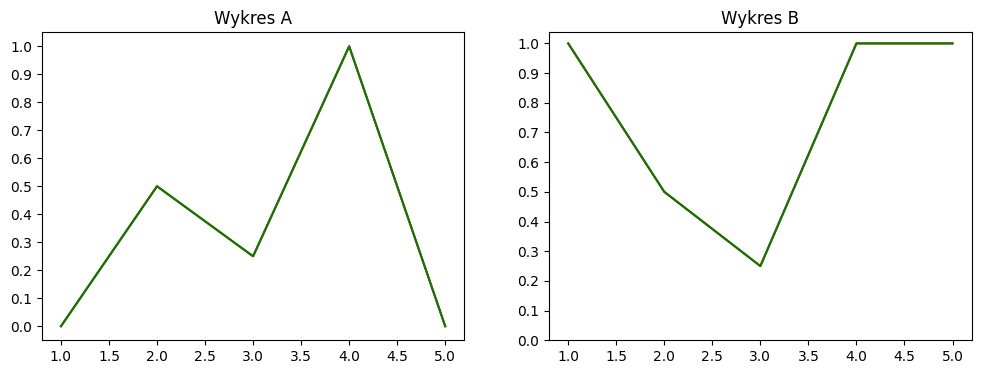

In [15]:
def plot_day5(wykresA_day5, wykresB_day5):
    wykresB = [1., 0.5, 0.25, 1., float(wykresB_day5)]
    wykresA = [0., 0.5, 0.25, 1., float(wykresA_day5)]
    wykresBp = [1., 0.5, 0.25, 1., 1.]
    wykresAp = [0., 0.5, 0.25, 1., 0.]
    x = [1, 2, 3, 4, 5]

    plt.figure(figsize=(12, 4))

    plt.subplot(1,2,1)
    plt.plot(x, wykresA, "r")
    plt.plot(x, wykresAp, "g")
    plt.title("Wykres A")
    plt.yticks(np.arange(0., 1.1, .1))

    plt.subplot(1,2,2)
    plt.plot(x, wykresB, "r")
    plt.plot(x, wykresBp, "g")
    plt.title("Wykres B")
    plt.yticks(np.arange(0., 1.1, .1))
    plt.show()
    
plot_day5(0., 1.)

### Przewidywania przed treningiem

In [16]:
with torch.inference_mode():
    przewidywaniaA = model.forward((torch.tensor([0., 0.5, 0.25, 1.])))
    przewidywaniaB = model.forward((torch.tensor([1., 0.5, 0.25, 1.])))

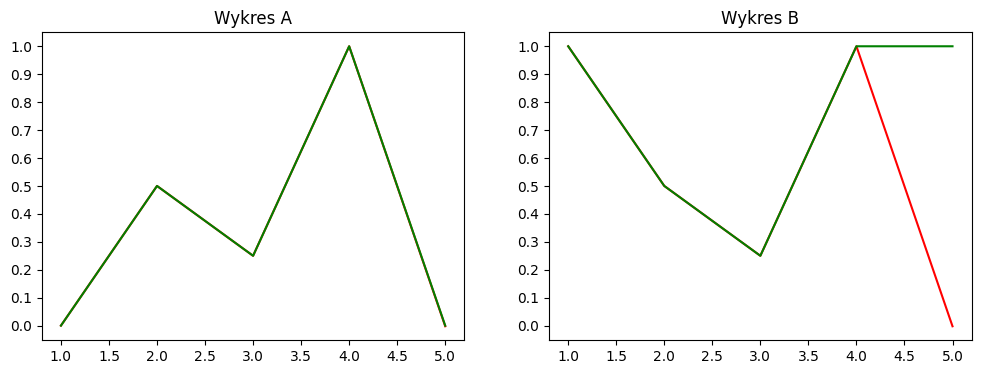

In [17]:
plot_day5(przewidywaniaA, przewidywaniaB)

### Normalny Trening

In [18]:
inputs = torch.tensor([[0., 0.5, 0.25, 1.], [1., 0.5, 0.25, 1.]])
lables = torch.tensor([0., 1.])

dataset = TensorDataset(inputs, lables)
dataloader = DataLoader(dataset)

training_time = timer()
for epoch in range(1, 1001):
    model.train()
    train_loss, train_acc = 0, 0
    
    for batch, (data, label) in enumerate(dataloader):
        data, label = data.to('cuda'), label.to('cuda')
        
        #1. Forward
        logits = model(data.squeeze())
        #2. Loss
        loss = (logits - label)**2
        train_loss += loss.item()
        #3. zeroGrad
        optimizer.zero_grad()
        #4. Backward
        loss.backward()
        #5. Optimizer step
        optimizer.step()
    
    train_loss /= len(dataloader)
    if (epoch%100 == 0):
        print(f"Epoch: {epoch} | Loss: {train_loss}")

Norm_time = timer() - training_time
print(f"Czas treningu: {Norm_time}")

Epoch: 100 | Loss: 0.24818658828735352
Epoch: 200 | Loss: 0.2052048295736313
Epoch: 300 | Loss: 0.004051246196468128
Epoch: 400 | Loss: 0.0013920238034188515
Epoch: 500 | Loss: 0.0008224970799233233
Epoch: 600 | Loss: 0.0005707825776113395
Epoch: 700 | Loss: 0.00042892164046293146
Epoch: 800 | Loss: 0.00033813411601357757
Epoch: 900 | Loss: 0.0002752454248575731
Epoch: 1000 | Loss: 0.00022926190244643152
Czas treningu: 9.324402400001418


### Przewidywania po treningu

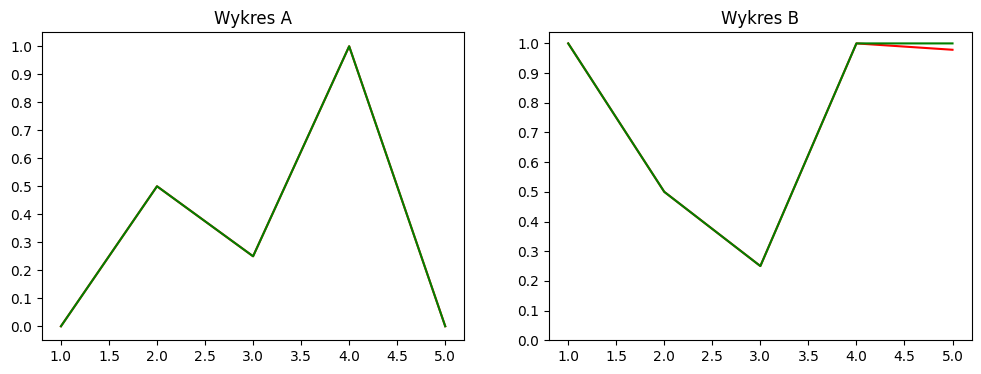

In [19]:
with torch.inference_mode():
    przewidywaniaA = model.forward((torch.tensor([0., 0.5, 0.25, 1.])))
    przewidywaniaB = model.forward((torch.tensor([1., 0.5, 0.25, 1.])))
plot_day5(przewidywaniaA, przewidywaniaB)

## Trening z lightning

In [20]:
modelLightning = LSTMbyHand()

#Lightning trainer
training_time = timer()
trainer = L.Trainer(max_epochs=1000)
trainer.fit(modelLightning, train_dataloaders=dataloader)

lightningv1_time = timer()-training_time
print(f"Training time with lightning: {lightningv1_time}")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type | Params
------------------------------
------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
C:\Users\Franek\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which ma

Epoch 999: 100%|██████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 103.22it/s, v_num=17]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|███████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 82.06it/s, v_num=17]
Training time with lightning: 22.04485580000619


### Przewidywania po treningu lightning

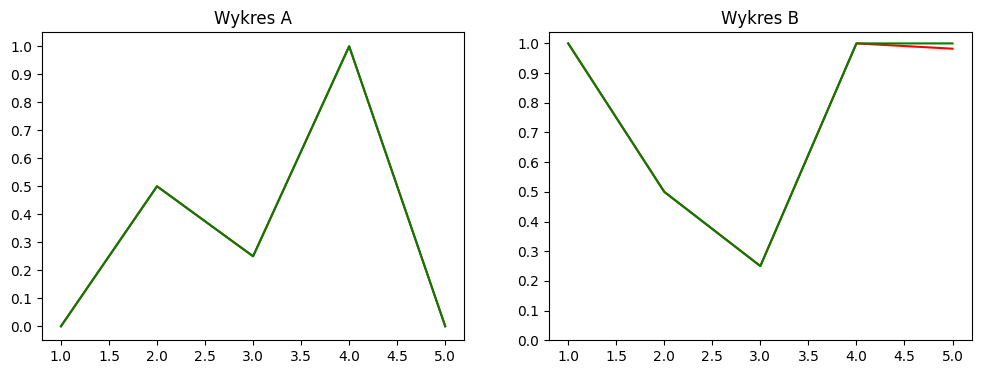

In [21]:
with torch.inference_mode():
    przewidywaniaA = modelLightning.forward((torch.tensor([0., 0.5, 0.25, 1.])))
    przewidywaniaB = modelLightning.forward((torch.tensor([1., 0.5, 0.25, 1.])))
plot_day5(przewidywaniaA, przewidywaniaB)

## Nowy model z użyciem nn.LSTM

In [22]:
class newLSTM(L.LightningModule):
    
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=1)
        
    def forward(self, input):
        input_T = input.view(len(input), 1)
        lstm_out, temp = self.lstm(input_T)
        return lstm_out[-1]
    
    def configure_optimizers(self):
        return Adam(self.parameters(), lr=0.01)
    
    def training_step(self, batch, batch_idx):
        input_i, label_i = batch
        output_i = self.forward(input_i[0])
        loss = (output_i - label_i)**2
        
        self.log("trin_loss", loss)
        
        if(label_i == 0):
            self.log("out_0", output_i)
        else:
            self.log("out_1", output_i)
            
        return loss

In [23]:
modelv2 = newLSTM().to('cuda')
optimizer = torch.optim.Adam(modelv2.parameters(), lr=0.01)

### Trenowanie Lightning v2

In [24]:
modelLightningv2 = newLSTM()

training_time = timer()
trainerv2 = L.Trainer(max_epochs=1000, log_every_n_steps=2)
trainerv2.fit(modelLightningv2, train_dataloaders=dataloader)

lightningv2_time = timer()-training_time
print(f"Training time with lightning: {lightningv2_time}")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type | Params
------------------------------
0 | lstm | LSTM | 16    
------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)


Epoch 999: 100%|██████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 199.51it/s, v_num=18]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 153.56it/s, v_num=18]
Training time with lightning: 13.589583100001619


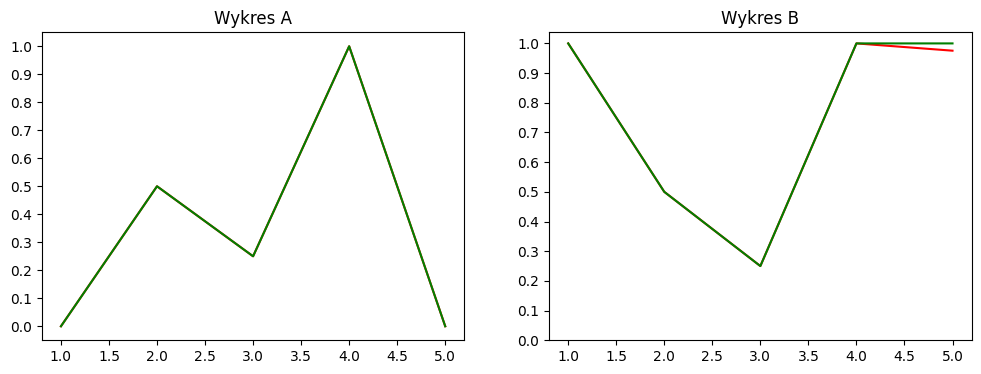

In [25]:
with torch.inference_mode():
    przewidywaniaA = modelLightningv2.forward((torch.tensor([0., 0.5, 0.25, 1.])))
    przewidywaniaB = modelLightningv2.forward((torch.tensor([1., 0.5, 0.25, 1.])))
plot_day5(przewidywaniaA, przewidywaniaB)

### Normalne trenowanie v2

In [26]:
training_time = timer()

for epoch in range(1, 1001):
    modelv2.train()
    train_loss_v2 = 0
    
    for batch, (data, label) in enumerate(dataloader):
        data, label = data.to('cuda'), label.to('cuda')
        
        #1. Forward
        logits = modelv2(data.squeeze())
        #2. Loss
        loss_v2 = (logits - label)**2
        train_loss_v2 += loss_v2.item()
        #3. zeroGrad
        optimizer.zero_grad()
        #4. Backward
        loss_v2.backward()
        #5. Optimizer step
        optimizer.step()
    
    train_loss_v2 /= len(dataloader)
    if (epoch%100 == 0):
        print(f"Epoch: {epoch} \t| Loss: {train_loss_v2}")

Norm_time_v2 = timer() - training_time
print(f"Czas treningu: {Norm_time_v2}")

Epoch: 100 	| Loss: 0.249712273478508
Epoch: 200 	| Loss: 0.24811885505914688
Epoch: 300 	| Loss: 0.2388654127717018
Epoch: 400 	| Loss: 0.036670272587798536
Epoch: 500 	| Loss: 0.0044583929243344755
Epoch: 600 	| Loss: 0.0022820043338640517
Epoch: 700 	| Loss: 0.0014605471706605755
Epoch: 800 	| Loss: 0.0010372277295598309
Epoch: 900 	| Loss: 0.0007912481177640984
Epoch: 1000 	| Loss: 0.000624494302522649
Czas treningu: 2.926950699998997


In [27]:
Comparision = pd.DataFrame([{'Trainer': "Własne trenowanie", "Loss": train_loss, "Czas": Norm_time},
                            {'Trainer': "Lightning v1", "Loss": trainer.callback_metrics['trin_loss'].item(), "Czas": lightningv1_time},
                            {'Trainer': "Własne trenowanie v2", "Loss": train_loss_v2, "Czas": Norm_time_v2},
                            {'Trainer': "Lightning v2", "Loss": trainerv2.callback_metrics['trin_loss'].item(), "Czas": lightningv2_time}])

Comparision

,Trainer,Loss,Czas
0,Własne trenowanie,0.000229,9.324402
1,Lightning v1,0.000316,22.044856
2,Własne trenowanie v2,0.000624,2.926951
3,Lightning v2,0.000601,13.589583
